In [1]:
import warnings
warnings.filterwarnings("ignore")

import mysql.connector as sql
import pandas as pd
import numpy as np
from datetime import datetime
import csv

db = sql.connect(
    host="localhost",
    user="root",
    passwd="asdf1234",
    database="tsf"
)
cursor = db.cursor()
mbb = pd.read_sql('SELECT * FROM tsf_mbb', con = db)
#pbb = pd.read_sql('SELECT * FROM tsf_pbb', con = db)

mbb['Date'] = pd.to_datetime(mbb['Date'])

### 0. Data Preparation

In [2]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if (df[cols[i]].min() > np.iinfo(np.int8).min) and (df[cols[i]].max() < np.iinfo(np.int8).max):
                df[cols[i]] = df[cols[i]].astype(np.int8)
                
            elif (df[cols[i]].min() > np.iinfo(np.int16).min) and (df[cols[i]].max() < np.iinfo(np.int16).max):
                df[cols[i]] = df[cols[i]].astype(np.int16)
                
            elif (df[cols[i]].min() > np.iinfo(np.int32).min) and (df[cols[i]].max() < np.iinfo(np.int32).max):
                df[cols[i]] = df[cols[i]].astype(np.int32)
            
            else:
                df[cols[i]] = df[cols[i]].asypes(np.int64)
        elif 'float' in str(t):
            if (df[cols[i]].min() > np.finfo(np.float16).min) and (df[cols[i]].max() < np.finfo(np.float16).max):
                df[cols[i]] = df[cols[i]].astype(np.float16)
                
            elif (df[cols[i]].min() > np.finfo(np.float32).min) and (df[cols[i]].max() < np.finfo(np.float32).max):
                df[cols[i]] = df[cols[i]].astype(np.float32)
            
            else:
                df[cols[i]] = df[cols[i]].asypes(np.float64)
        elif t == object:
            if cols[i] == 'date':
                #df[cols[i]] = pd.to_datetime(df[cols[i]], format = '%Y-%m-%d')
                pass
            else:
                #df[cols[i]] = df[cols[i]].astypes('category')
                pass
    return df

In [3]:
#1. Apply downcasting method on dataset
#2. Select the data within the covid period

mbb = downcast(mbb)
mbb = mbb[(mbb['Date'] >= '2020-03-18') & (mbb['Date'] < datetime.today())]
print(mbb.shape)

(521, 7)


In [4]:
#3. Check the column, Close whether it exists 0 or null values
print(mbb[mbb['Close'] == 0])
print(mbb[mbb['Close'].isnull()])

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj_Close, Volume]
Index: []
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj_Close, Volume]
Index: []


In [5]:
mbb = mbb[mbb['Close'] > 0]

### 1. Anomaly Detection - Isolation Forest

In [6]:
mbb_len = mbb.shape[0]

In [7]:
from sklearn.ensemble import IsolationForest

contamination = 0.10
anomaly_model = IsolationForest(n_estimators = 100, contamination = contamination, max_samples = mbb_len, max_features = 6)

In [8]:
%%time

#split the dataset into train & test dataset based on the periodic range

train_df = mbb[mbb['Date'] <= '2021-12-31']
test_df = mbb[mbb['Date'] > '2021-12-31']

#df = mbb[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']]
#df.reset_index(drop=True, inplace=True)

Wall time: 2 ms


In [9]:
train_df = train_df[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']]
train_df.reset_index(drop = True, inplace = True)

test_df = test_df[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']]
test_df.reset_index(drop = True, inplace = True)

In [10]:
#2. Fit the train dataset into the isolation forest model
anomaly_model.fit(train_df)

IsolationForest(contamination=0.1, max_features=6, max_samples=521)

In [11]:
#3. Predict the anomaly
pred = pd.Series(anomaly_model.predict(train_df))
test_df = test_df.merge(pred.rename('Anomaly_Flag'), left_index = True, right_index = True)
test_df

,Open,High,Low,Close,Adj_Close,Volume,Anomaly_Flag
0,8.289062,8.343750,8.257812,8.328125,8.328125,1600100,1
1,8.328125,8.359375,8.296875,8.359375,8.359375,3812600,1
2,8.351562,8.359375,8.312500,8.351562,8.351562,4009700,1
3,8.359375,8.359375,8.289062,8.296875,8.296875,4650200,1
4,8.296875,8.320312,8.273438,8.320312,8.320312,4304200,1
...,...,...,...,...,...,...,...
77,8.890625,8.976562,8.890625,8.953125,8.953125,11014100,-1
78,8.937500,9.023438,8.906250,8.976562,8.976562,8299600,-1
79,9.101562,9.101562,9.000000,9.039062,9.039062,13334200,-1
80,9.046875,9.078125,8.976562,9.070312,9.070312,6499400,-1


In [12]:
date = mbb[mbb['Date'] > '2021-12-31']['Date'].reset_index(drop = True)
test_df = test_df.merge(date.rename('Date'), left_index = True, right_index = True)
test_df

,Open,High,Low,Close,Adj_Close,Volume,Anomaly_Flag,Date
0,8.289062,8.343750,8.257812,8.328125,8.328125,1600100,1,2022-01-03
1,8.328125,8.359375,8.296875,8.359375,8.359375,3812600,1,2022-01-04
2,8.351562,8.359375,8.312500,8.351562,8.351562,4009700,1,2022-01-05
3,8.359375,8.359375,8.289062,8.296875,8.296875,4650200,1,2022-01-06
4,8.296875,8.320312,8.273438,8.320312,8.320312,4304200,1,2022-01-07
...,...,...,...,...,...,...,...,...
77,8.890625,8.976562,8.890625,8.953125,8.953125,11014100,-1,2022-04-26
78,8.937500,9.023438,8.906250,8.976562,8.976562,8299600,-1,2022-04-27
79,9.101562,9.101562,9.000000,9.039062,9.039062,13334200,-1,2022-04-28
80,9.046875,9.078125,8.976562,9.070312,9.070312,6499400,-1,2022-04-29


In [13]:
test_df = test_df[['Date','Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'Anomaly_Flag']]
test_df

,Date,Open,High,Low,Close,Adj_Close,Volume,Anomaly_Flag
0,2022-01-03,8.289062,8.343750,8.257812,8.328125,8.328125,1600100,1
1,2022-01-04,8.328125,8.359375,8.296875,8.359375,8.359375,3812600,1
2,2022-01-05,8.351562,8.359375,8.312500,8.351562,8.351562,4009700,1
3,2022-01-06,8.359375,8.359375,8.289062,8.296875,8.296875,4650200,1
4,2022-01-07,8.296875,8.320312,8.273438,8.320312,8.320312,4304200,1
...,...,...,...,...,...,...,...,...
77,2022-04-26,8.890625,8.976562,8.890625,8.953125,8.953125,11014100,-1
78,2022-04-27,8.937500,9.023438,8.906250,8.976562,8.976562,8299600,-1
79,2022-04-28,9.101562,9.101562,9.000000,9.039062,9.039062,13334200,-1
80,2022-04-29,9.046875,9.078125,8.976562,9.070312,9.070312,6499400,-1


In [14]:
test_df['Yesterday_Close'] = test_df['Close'].shift(1)
#df['percentage_change'] = ((df['Close'] - df['shift']) / df['Close']) * 100
test_df['Percentage_Change'] = ((test_df['Close'] - test_df['Yesterday_Close']) / test_df['Close']) * 100
test_df['Percentage_Change'] = np.round(test_df['Percentage_Change'],2)
test_df

,Date,Open,High,Low,Close,Adj_Close,Volume,Anomaly_Flag,Yesterday_Close,Percentage_Change
0,2022-01-03,8.289062,8.343750,8.257812,8.328125,8.328125,1600100,1,NaN,NaN
1,2022-01-04,8.328125,8.359375,8.296875,8.359375,8.359375,3812600,1,8.328125,0.370117
2,2022-01-05,8.351562,8.359375,8.312500,8.351562,8.351562,4009700,1,8.359375,-0.090027
3,2022-01-06,8.359375,8.359375,8.289062,8.296875,8.296875,4650200,1,8.351562,-0.660156
4,2022-01-07,8.296875,8.320312,8.273438,8.320312,8.320312,4304200,1,8.296875,0.280029
...,...,...,...,...,...,...,...,...,...,...
77,2022-04-26,8.890625,8.976562,8.890625,8.953125,8.953125,11014100,-1,8.890625,0.700195
78,2022-04-27,8.937500,9.023438,8.906250,8.976562,8.976562,8299600,-1,8.953125,0.260010
79,2022-04-28,9.101562,9.101562,9.000000,9.039062,9.039062,13334200,-1,8.976562,0.689941
80,2022-04-29,9.046875,9.078125,8.976562,9.070312,9.070312,6499400,-1,9.039062,0.340088


In [15]:
test_df = test_df.replace(np.nan, 0)

In [16]:
test_df.to_csv('C:/Users/Hoe/Desktop/Learning/Python/Project 9 - Anomaly Detection/data/result_v2.csv')

### 2. Insert into mysql table, anomaly_isolation_mbb

In [17]:
#df['Date'] = df['Date'].astype('str')
#df_last_row = df.tail(1)
#df_last_row.to_csv('C:/Users/Hoe/Desktop/Learning/Python/Project 9 - Anomaly Detection/data/latest_result.csv', index = False)

In [18]:
#import csv
#sql_data_list = []
#db_table = 'anomaly_isolation_mbb'
#with open('C:/Users/Hoe/Desktop/Learning/Python/Project 9 - Anomaly Detection/latest_result.csv') as csvfile:
#    csv_data = csv.reader(csvfile, delimiter = ',') #read the csv files
#    next(csv_data, None)  # skip the headers

    #convert the column type from csv files
#    sql_data_list = [] #sql data

#    for df_last_row in csv_data:
#        value = (df_last_row[0], df_last_row[1], df_last_row[2], df_last_row[3], df_last_row[4], df_last_row[5],
#                 df_last_row[6], df_last_row[7], df_last_row[8], df_last_row[9])
#        sql_data_list.append(value)
        
#query = '''
#INSERT INTO anomaly_isolation_mbb
#(Date, Open, High, Low, Close, Adj_Close, Volume, Anomaly_Flag, Yesterday_Close, Percentage_Change) 
#VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
#'''


#cursor.executemany(query, sql_data_list)
#db.commit()

#query = f"INSERT INTO {db_table} (Date, Open, High, Low, Close, Adj_Close, Volume) VALUES(%s, %s, %s, %s, %s, %s, %s)"


### 3. Plot Visualization (Matplotlib)

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline

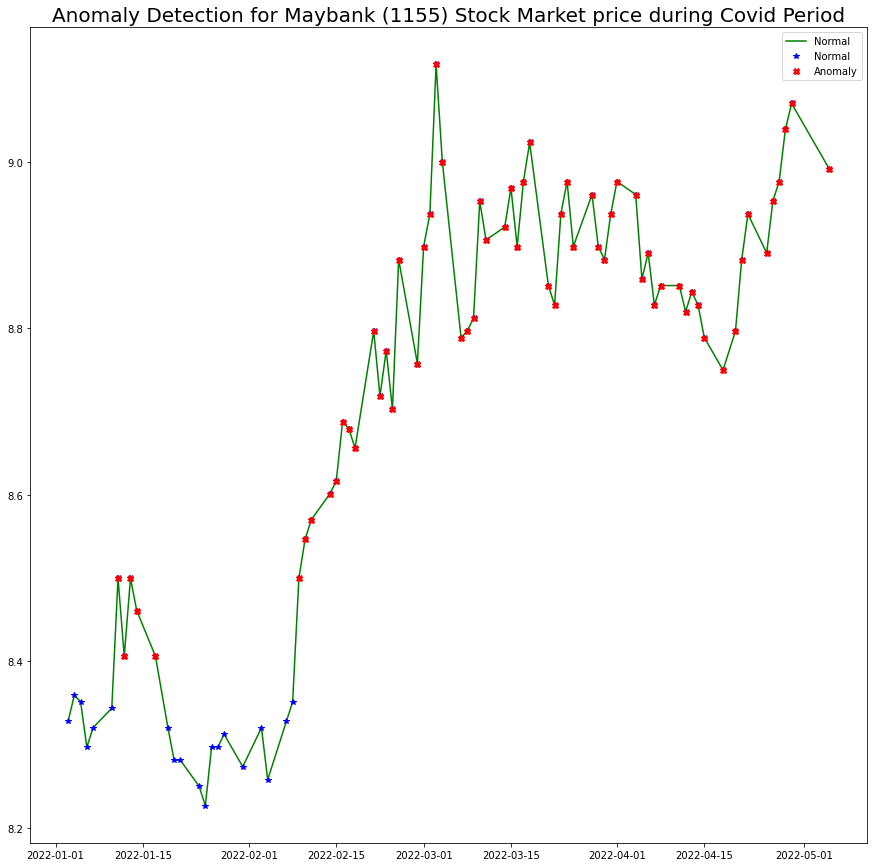

In [31]:
plt.figure(figsize = (15, 15))

test = test_df.copy()
test.set_index('Date', inplace = True)
anomaly = test[test['Anomaly_Flag'] == -1]


plt.plot(test['Close'], color = 'Green', label = 'Normal')
plt.plot(test['Close'], linestyle = 'none', color = 'Blue', marker = '*' , label = 'Normal')
plt.plot(anomaly['Close'], linestyle = 'none', marker = 'X', color = 'Red', label = 'Anomaly')

plt.title('Anomaly Detection for Maybank (1155) Stock Market price during Covid Period', size = 20)
plt.legend(loc = 'best')
plt.show()

In [21]:
test_df

,Date,Open,High,Low,Close,Adj_Close,Volume,Anomaly_Flag,Yesterday_Close,Percentage_Change
0,2022-01-03,8.289062,8.343750,8.257812,8.328125,8.328125,1600100,1,0.000000,0.000000
1,2022-01-04,8.328125,8.359375,8.296875,8.359375,8.359375,3812600,1,8.328125,0.370117
2,2022-01-05,8.351562,8.359375,8.312500,8.351562,8.351562,4009700,1,8.359375,-0.090027
3,2022-01-06,8.359375,8.359375,8.289062,8.296875,8.296875,4650200,1,8.351562,-0.660156
4,2022-01-07,8.296875,8.320312,8.273438,8.320312,8.320312,4304200,1,8.296875,0.280029
...,...,...,...,...,...,...,...,...,...,...
77,2022-04-26,8.890625,8.976562,8.890625,8.953125,8.953125,11014100,-1,8.890625,0.700195
78,2022-04-27,8.937500,9.023438,8.906250,8.976562,8.976562,8299600,-1,8.953125,0.260010
79,2022-04-28,9.101562,9.101562,9.000000,9.039062,9.039062,13334200,-1,8.976562,0.689941
80,2022-04-29,9.046875,9.078125,8.976562,9.070312,9.070312,6499400,-1,9.039062,0.340088
